In [8]:
from datetime import datetime
import itertools
import json
import math
import os
import sys

import importlib
from joblib import Parallel, delayed
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy
from scipy.spatial import KDTree
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from utils import data_utils, data_loader, shape_utils

importlib.reload(data_utils)
importlib.reload(data_loader)
importlib.reload(shape_utils)

from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

RUN_FOLDER = "../results/debug/"
NETWORK = "kcm"

In [9]:
kcm_inputs = data_utils.load_all_inputs(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_all_inputs(RUN_FOLDER, "atb/")

In [10]:
# Sample shingle ids and choose dist/time ranges to test
if NETWORK=="kcm":
    shingle_ids = pd.unique(kcm_inputs['test_traces']['shingle_id'])
    traces = kcm_inputs['test_traces']
else:
    shingle_ids = pd.unique(atb_inputs['test_traces']['shingle_id'])
    traces = atb_inputs['test_traces']
shingle_id_sample = np.random.choice(shingle_ids, 100, replace=False)
d_buffers = np.linspace(1,1000,20)
t_buffers = np.linspace(1,60*10,20)
b_buffer = 10
orthogonal = True
# Test shingle data against all other data
shingle_traces = traces[traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s','shingle_id']]
shingle_groups = shingle_traces.groupby('shingle_id')
adj_traces = traces[~traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s']].values
# Save results for each shingle, and buffer combination
targets_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))
preds_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))

In [11]:
# Parallel: 5min with 10 samples, 20x20 buffers
def parallel_get_metrics(d):
    dist_buffer = d_buffers[d]
    results = []
    for t, t_buffer in enumerate(t_buffers):
        res = shingle_groups.apply(shape_utils.get_adjacent_metric, adj_traces, dist_buffer, t_buffer, b_buffer=b_buffer, orthogonal=orthogonal)
        targets = np.array([x[0] for x in res])
        preds = np.array([x[1] for x in res])
        # If all nan, fill with zeros
        if sum(~np.isnan(targets))==0:
            targets = np.nan_to_num(targets, nan=1.0)
        else:
            targets[np.isnan(targets)] = np.mean(targets[~np.isnan(targets)])
        # If some nan, fill with mean
        if sum(~np.isnan(preds))==0:
            preds = np.nan_to_num(preds, nan=1.0)
        else:
            preds[np.isnan(preds)] = np.mean(preds[~np.isnan(preds)])
        results.append((targets, preds, d, t))
    return results
# Each item in the results corresponds to a distance buffer; it has n subitems, 1 for each time buffer
# Within a d-t buffer, there are 4 values; (targets, preds, d_buffer idx, t_buffer idx)
res_parallel = Parallel(n_jobs=-2)(delayed(parallel_get_metrics)(x) for x in range(len(d_buffers)))

In [12]:
# Expand parallel adjacent metric results
for d_idx in range(len(res_parallel)):
    for t_idx in range(len(res_parallel[0])):
        targets = res_parallel[d_idx][t_idx][0]
        preds = res_parallel[d_idx][t_idx][1]
        targets_res[:,d_idx,t_idx] = targets
        preds_res[:,d_idx,t_idx] = preds

In [13]:
# Get R2 value for each combination of preds and targets and for each d and t buffer
r_values = np.empty((preds_res.shape[1], preds_res.shape[2]))
for d in range(preds_res.shape[1]):
    for t in range(preds_res.shape[2]):
        R2, x_plt, y_plt = shape_utils.fit_poly(preds_res[:,d,t], targets_res[:,d,t])
        r_values[d,t] = R2
r_values

/var/folders/6p/76scpql109v8rhf5gm61sr4c0000gn/T/ipykernel_16218/1841841868.py:5: RankWarning: Polyfit may be poorly conditioned
  R2, x_plt, y_plt = shape_utils.fit_poly(preds_res[:,d,t], targets_res[:,d,t])
/var/folders/6p/76scpql109v8rhf5gm61sr4c0000gn/T/ipykernel_16218/1841841868.py:5: RankWarning: Polyfit may be poorly conditioned
  R2, x_plt, y_plt = shape_utils.fit_poly(preds_res[:,d,t], targets_res[:,d,t])
/var/folders/6p/76scpql109v8rhf5gm61sr4c0000gn/T/ipykernel_16218/1841841868.py:5: RankWarning: Polyfit may be poorly conditioned
  R2, x_plt, y_plt = shape_utils.fit_poly(preds_res[:,d,t], targets_res[:,d,t])
/var/folders/6p/76scpql109v8rhf5gm61sr4c0000gn/T/ipykernel_16218/1841841868.py:5: RankWarning: Polyfit may be poorly conditioned
  R2, x_plt, y_plt = shape_utils.fit_poly(preds_res[:,d,t], targets_res[:,d,t])
/var/folders/6p/76scpql109v8rhf5gm61sr4c0000gn/T/ipykernel_16218/1841841868.py:5: RankWarning: Polyfit may be poorly conditioned
  R2, x_plt, y_plt = shape_utils.fi

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05781185, 0.05781185, 0.05781185, 0.05781185, 0.05781185],
       [0.        , 0.02744484, 0.04325101, 0.07192584, 0.00040024,
        0.00293591, 0.00044687, 0.00029417, 0.0036286 , 0.00088632,
        0.00086696, 0.01054598, 0.00674832, 0.0060828 , 0.00611342,
        0.00717875, 0.00688474, 0.00624922, 0.00574588, 0.00476214],
       [0.        , 0.02762259, 0.02226076, 0.02310299, 0.01818891,
        0.0156316 , 0.02001432, 0.01961068, 0.01113549, 0.02204825,
        0.01343171, 0.04349664, 0.03362498, 0.02970595, 0.0300191 ,
        0.03306226, 0.02336414, 0.02364602, 0.02249461, 0.02127598],
       [0.        , 0.0683219 , 0.01689224, 0.03161026, 0.04078936,
        0.04018375, 0.02689172, 0.02710205, 0.01387316, 0.0262318 ,
        0.02863976, 0.06005909, 0.04788089, 0

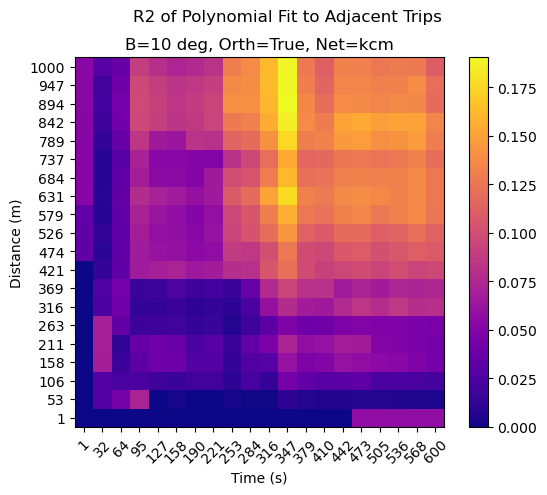

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(r_values, origin="lower", cmap="plasma")
fig.suptitle("R2 of Polynomial Fit to Adjacent Trips")
ax.set_title(f"B={b_buffer} deg, Orth={str(orthogonal)}, Net={NETWORK}")
ax.set_xlabel("Time (s)")
ax.set_xticks([x for x in range(len(t_buffers))])
ax.set_xticklabels([str(int(x)) for x in t_buffers], rotation=45)
ax.set_ylabel("Distance (m)")
ax.set_yticks([y for y in range(len(d_buffers))])
ax.set_yticklabels([str(int(y)) for y in d_buffers])
cbar = fig.colorbar(im, ax=ax)
plt.draw()
plt.savefig(f"../plots/R2_poly_adj_small_{b_buffer}_{str(orthogonal)}_{NETWORK}.png")
plt.show()